In [1]:
import os
import csv
import gzip
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
path='/content/20230320_UkraineCombinedTweetsDeduped.csv.gzip'
data = pd.read_csv(path, compression='gzip')
#data.head(5)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202188 entries, 0 to 202187
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Unnamed: 0               202188 non-null  int64 
 1   userid                   202188 non-null  int64 
 2   username                 202188 non-null  object
 3   acctdesc                 155424 non-null  object
 4   location                 105138 non-null  object
 5   following                202188 non-null  int64 
 6   followers                202188 non-null  int64 
 7   totaltweets              202188 non-null  int64 
 8   usercreatedts            202188 non-null  object
 9   tweetid                  202188 non-null  int64 
 10  tweetcreatedts           202188 non-null  object
 11  retweetcount             202188 non-null  int64 
 12  text                     202188 non-null  object
 13  hashtags                 202188 non-null  object
 14  language            

In [4]:
data.shape

(202188, 29)

**Analysing the number of tweets in different languages. As per the below graph, majority of the tweets are in English. The study will only focus on tweets in English** 

In [5]:
data.language.value_counts()

en     134909
es      11801
fr      11454
it      10978
de       9640
        ...  
si          3
km          2
ps          2
sd          1
ckb         1
Name: language, Length: 61, dtype: int64

<Axes: ylabel='language'>

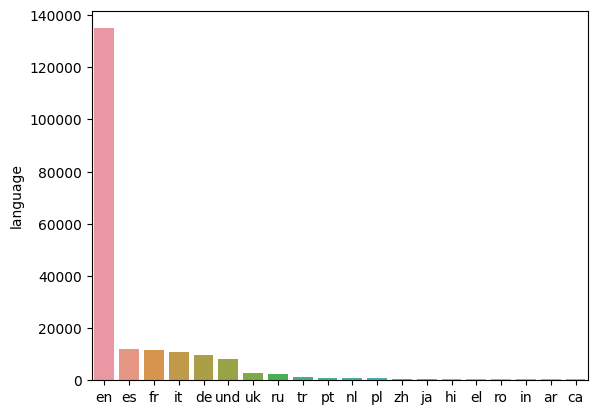

In [6]:
sns.barplot(x= data.language.value_counts()[:20].index,y=data.language.value_counts()[:20])

**Drop tweets not in English language**

In [7]:
data = data[data.language == 'en']
print(data.shape[0], "tweets are in english language.")

134909 tweets are in english language.


**Remove any duplicate tweets**

In [8]:
data = data.drop_duplicates(subset='text', keep='first', inplace=False)
data.shape

(42214, 29)

**Split tweet created timestamp into date and time columns**

In [9]:
#Split tweetcreatedtimestamp into date and time columns for analysis purposes
data[["tweetcreated_date","tweetcreated_time"]] = data["tweetcreatedts"].str.split(expand=True)

**Remove rows with Null values**

In [10]:
#remove any null rows where either tweet, date and time are null 
data = data.dropna(subset=['text', 'tweetcreated_date', 'tweetcreated_time'])
data.shape

(42214, 31)

**Top 10 most retweeted tweets on the basis of retweeted count** 

In [36]:
sorted_tweets = data[['text','retweetcount']].sort_values(by = 'retweetcount', ascending=False)
sorted_tweets.head(10)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,retweetcount
39981,My daughter and I surviving the night in Ukraine. We are real people at war with crazy dictator and we need the world’s support right now\n\n#StandWithUkraine https://t.co/FvdmY4GACj,99327
18239,"24 kidnapped Ukrainian children from #Russia-occupied Donetsk region are passed to adoptive families in Novosibirsk, 3600 km away from home\n\nSecrecy of adoption will never let them learn were their parents killed, sent to concentration camps or deported\n\n#russiaisateroriststate https://t.co/nxT90VVU8y",9860
4294,Situation in #Ukraine: #ICC judges issue arrest warrants against Vladimir Vladimirovich Putin and Maria Alekseyevna Lvova-Belova\nRead more ⤵️\n https://t.co/5OMC7Xuuy5,8326
2012,"I want to thank again every American who voted for Biden. When you were celebrating Trump is no longer a threat to humanity, I was drinking champagne for the historical moment too. But little did I know that moment would save soo many lives in #Ukraine️. You &amp; your @POTUS are 😎 https://t.co/DoappUX5jw",7777
2443,"Sergei is a hero.\n\nDuring a battle in #Bakhmut, he dragged 9 wounded men to safety, applied 3 tourniquets, saved a dying soldier AND was firing his rifle in combat.\n\nSergei was trained by Sons of Liberty International (@OfficialSOLI) trainer Jason.\n\n#UkraineWillWin #Ukraine #NAFO https://t.co/R94CRWGRaD",7696
149323,"Shocking! This is an actual freight train moving over a twisted, ""bendy"" railway track linking Ohio and Indiana in the USA!! \n\nIt's like a 4th world country.\n\nAmerica should fix its sh*thole infrastructure rather than waging endless wars.\n\n#Russia #Ukraine #China https://t.co/EPs9rca9pL",7075
179526,"Pay attention to the IR leader's beard, it is full of execution ropes. This is the real face of the regime that has killed many people in #Iran, Syria, Iraq, Yemen, #Ukraine, etc. Help the people of Iran to overthrow it.\n#MahsaAmini \n@ZelenskyyUa \n@EUCouncil \n@vp\n@cnn\n@Ap\n@UN https://t.co/A35LiNQWfV",6148
7128,"On this day in 2014, a #Russia|n Buk shot down a passenger aircraft #MH17 flying at 10 km from Amsterdam to Kuala Lumpur over #Donetsk region in eastern #Ukraine. \n\nAll 283 passengers and 15 crew were killed.\n\n https://t.co/O20x27pHJy",5825
20976,🇺🇦 Glory to Ukraine and it's Soldiers 🇺🇦\n#UkraineWar https://t.co/S4lWhnuxqu,5638
30429,THREAD: Proof that you are a Nazi if you don't #StandWithUkraine 🇺🇦,5638


**Top most tweets from the most followed user accounts**

In [37]:
popular_tweets = data[['text','followers']].sort_values(by = 'followers', ascending=False)
popular_tweets.head(10)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,followers
143521,"'Dear friends' Xi and Putin meet in #Moscow as #Ukraine war rages \n\nMoscow said the charge was one of several ""clearly hostile displays"" and opened a criminal case against the ICC prosecutor and judges. Beijing said the warrant reflected double standards\n\nhttps://t.co/UoRaxPG6U7",14685776
116774,Chinese leader #XiJinping told President #VladimirPutin that he was convinced that Putin enjoyed the #Russian people's support ahead of a presidential election scheduled for next year: Reuters,14685770
112821,#Russian President #VladimirPutin tells #Chinese President #XiJinping that they will discuss China's #Ukraine peace plan: Reuters\n\nChinese President Xi Jinping is in #Moscow for a three-day state visit to Russia. https://t.co/JZFlJZcvcj,14685748
73154,#China says #ICC should avoid 'double standards' after #Putin warrant \n\nThe International Criminal Court on Friday announced an arrest warrant for Putin on the accusation of unlawfully deporting #Ukrainian children.\nhttps://t.co/U0Nqzxr3b2,14685719
77039,#Chinese leader #XiJinping arrives in Moscow to meet with #Russian President #VladimirPutin \n\n#China and #Russia have described Xi’s trip as part of efforts to further deepen their “no-limits friendship.”\nhttps://t.co/jLQSirSPfK,14685689
6948,🐼Meet the giant #pandas Ru Yi and Ding Ding! The pair has been star attraction of the #Moscow Zoo since arrival in 2019. https://t.co/rlCPkYCMUv,13097476
20670,"As flowers bloom and buds sprout out from trees, an arboretum in #Sochi, #Russia has attracted tourists who are enjoying the beautiful springtime. https://t.co/n6yMZ5aXzq",13097462
26681,"Giant pandas help advance friendship between #China, #Russia https://t.co/yDCDAsMF46",13097462
72184,Highlights and major milestones in bilateral ties between #China and Russia #CGTNGraphics https://t.co/26CfTErIFf,13097216
77635,Russia welcomes Chinese President #XiJinping for state visit https://t.co/g3F5QYL4n6,13097215


**Tweets by location**

*As majority of the tweets are missing location, this is not an useful information and can be dropped.* 

In [13]:
data['location'].fillna("missing location", inplace=True)

<Axes: >

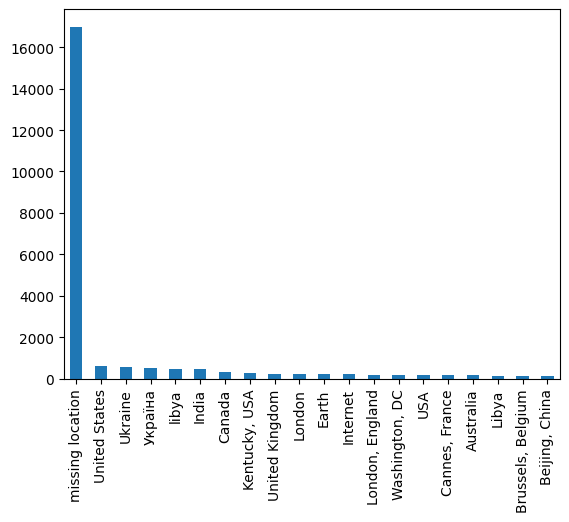

In [14]:
data.location.value_counts()[:20].plot.bar()

**Hashtag analysis**

In [15]:
data[['hashtags']].head(5)

,hashtags
1,"[{'text': 'RussianWarCrimes', 'indices': [71, ..."
2,"[{'text': 'NSTleader', 'indices': [0, 10]}, {'..."
4,"[{'text': 'UkraineWar', 'indices': [26, 37]}, ..."
5,"[{'text': 'UkraineWar', 'indices': [58, 69]}, ..."
6,"[{'text': 'UkraineRussiaWar️', 'indices': [21,..."


In [16]:
def extract_hashtags(hash):
    hashtags = []
    
    a = eval(str(hash))
    
    for item in a:
        hashtags.append((str(item["text"]).lower()))
        hashtags = list(set(hashtags))
        
    return hashtags

In [17]:
hashtagsListCollection = data["hashtags"].apply(extract_hashtags)

In [18]:
allHashtagsList = []
for hashtagsList in hashtagsListCollection:
  for hashtag in hashtagsList:
    allHashtagsList.append(hashtag)

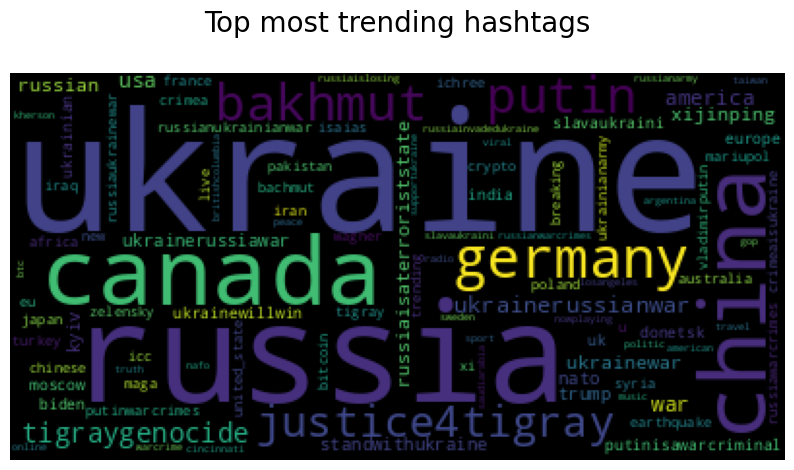

In [19]:
# Generate the word cloud
stopwords_set = set(stopwords.words('english'))
wordcloud = WordCloud(background_color="black",
                      stopwords = stopwords_set,
                      max_words= 100,
                      contour_width = 8,
                      contour_color = "white",
                      collocations=False).generate(" ".join(allHashtagsList))
                      
# Visualize the word cloud
fig = plt.figure(1, figsize = (10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Top most trending hashtags\n", fontsize=20)
plt.show()

**Create a subset of columns that are the most useful for our analysis**

In [20]:
final_df = data[['text', 'tweetcreated_date', 'tweetcreated_time']]
final_df.head(5)

,text,tweetcreated_date,tweetcreated_time
1,Success is given to seekers✨\n\nVideo out now!...,2023-03-20,00:00:00
2,#NSTleader Where is the International Criminal...,2023-03-20,00:00:00
4,Russia’s combat losses in #UkraineWar on all f...,2023-03-20,00:00:00
5,🇺🇦Ukraine War Footage 🔥🔥🔥🔥\n\n➡️➡️➡️ Follow fo...,2023-03-20,00:00:00
6,British Intelligence #UkraineRussiaWar️ map as...,2023-03-20,00:00:00


**Creating a list of Contraction words**

In [21]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are",
"doin":"doing"
}

**Cleaning the text**

In [22]:
def text_preprocessing(text):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Expand contractions
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    text = re.sub(r'@([^\s]+)','',text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\&[a-z]*\;', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    patterns = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F" 
        u"\U0001F300-\U0001F5FF" 
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags = re.UNICODE)
    text = patterns.sub(r'', text)
    text = re.sub(r'\'', ' ', text) 
    text = re.sub(r'[^a-zA-Z]+',' ',text)

    return text

In [23]:
final_df['data_clean_list'] = list(map(text_preprocessing, final_df.text))

<ipython-input-22-a9b5d958c606>:20: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')
<ipython-input-23-0269983188c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['data_clean_list'] = list(map(text_preprocessing, final_df.text))


In [24]:
pd.set_option('display.max_colwidth', 15000)
final_df.sample()

,text,tweetcreated_date,tweetcreated_time,data_clean_list
118714,"NB - Secretary of the National Security Council Oleksiy #Danilov commented on #Politico's publication about the #counteroffensive of the Armed Forces (two possible scenarios of the Ukrainian operation). ""We will definitely win"". #War_in_Ukraine https://t.co/75KJPB2F7S",2023-03-20,14:46:00,nb secretary of the national security council oleksiy danilov commented on politico s publication about the counteroffensive of the armed forces two possible scenarios of the ukrainian operation we will definitely win war in ukraine


**Creating Tokens**

In [25]:
def tokenise_text(text):
    # Tokenize each word
    text = nltk.WordPunctTokenizer().tokenize(text)

    # Lemmatize each word
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text if len(token)>1]
    return text

In [26]:
def to_string(text):
    # Convert list to string
    text = ' '.join(map(str, text))

    return text

In [27]:
final_df['tokenised_clean_list'] = list(map(tokenise_text, final_df.data_clean_list))
#removing stop words from the tokenised text
stopwords_list = stopwords.words('english')
final_df['tokenised_clean_list'] = [[word for word in line if word not in stopwords_list] for line in final_df['tokenised_clean_list']]
final_df['tokenised_clean_text'] = list(map(to_string, final_df['tokenised_clean_list']))

<ipython-input-27-4e39c251abe7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['tokenised_clean_list'] = list(map(tokenise_text, final_df.data_clean_list))
<ipython-input-27-4e39c251abe7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['tokenised_clean_list'] = [[word for word in line if word not in stopwords_list] for line in final_df['tokenised_clean_list']]
<ipython-input-27-4e39c251abe7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [28]:
pd.set_option('display.max_colwidth', 15000)
final_df.sample()

,text,tweetcreated_date,tweetcreated_time,data_clean_list,tokenised_clean_list,tokenised_clean_text
185158,Biden admin's Kirby ridicules Putin visit to Mariupol: ‘He has to know how badly he’s doing inside Ukraine’ https://t.co/ozma1AZzQ2 https://t.co/kuBXWsi79M #Foxnews #UkraineRussiaCrisis #russia #UkraineCrisis #RussiaInvadedUkraine #ukrainerussia #ukraine,2023-03-20,21:33:17,biden admin s kirby ridicules putin visit to mariupol he has to know how badly he s doing inside ukraine,"[biden, admin, kirby, ridicule, putin, visit, mariupol, know, badly, inside, ukraine]",biden admin kirby ridicule putin visit mariupol know badly inside ukraine


In [29]:
final_df[['text','tweetcreated_date', 'tweetcreated_time', 'tokenised_clean_text']].to_excel('./cleaned_data.xlsx')

**Creating Bag of Words**

In [30]:
import gensim
from collections import Counter
# Create Dictionary
id2word = gensim.corpora.Dictionary(final_df['tokenised_clean_list'])
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in final_df['tokenised_clean_list']]

**Calculating Topic Coherence score using C_v method**

*C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity*

In [31]:
from gensim.models import CoherenceModel
# Compute Coherence Score
number_of_topics = []
coherence_score_c_v = []
coherence_score_u_mass = []

for i in range(1,10):
  #running the base model
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           iterations=50,
                                           num_topics=i)
  #calculate the coherence score
  number_of_topics.append(i)
  coherence_model_lda = CoherenceModel(model=lda_model, texts=final_df['tokenised_clean_list'], dictionary=id2word, coherence='c_v')
  coherence_lda = coherence_model_lda.get_coherence()
  coherence_score_c_v.append(coherence_lda)
  coherence_model_lda_u_mass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=id2word, coherence='u_mass')
  coherence_lda_u_mass = coherence_model_lda_u_mass.get_coherence()
  coherence_score_u_mass.append(coherence_lda_u_mass)

topic_coherence = pd.DataFrame({'number_of_topics':number_of_topics,
                                'coherence_score_C_v':coherence_score_c_v,
                                'coherence_score_U_mass':coherence_score_u_mass})
  
print(topic_coherence)

   number_of_topics  coherence_score_C_v  coherence_score_U_mass
0                 1             0.281096               -3.121876
1                 2             0.565669               -2.679459
2                 3             0.371025               -5.075367
3                 4             0.520381               -3.592864
4                 5             0.479557               -4.640056
5                 6             0.451019               -6.827097
6                 7             0.414954               -5.044110
7                 8             0.422059               -6.048332
8                 9             0.467584               -6.339196


**Running the model with the optimal number of topics**

In [38]:
n_topics = 5

# Run the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} Word: {}".format(idx, topic))

Topic: 0 Word: 0.097*"putin" + 0.026*"go" + 0.022*"canada" + 0.019*"help" + 0.018*"get" + 0.016*"one" + 0.015*"russiawarcrimes" + 0.013*"time" + 0.013*"stop" + 0.011*"mariupol"
Topic: 1 Word: 0.066*"russian" + 0.027*"russiaisaterroriststate" + 0.020*"soldier" + 0.019*"world" + 0.018*"say" + 0.015*"support" + 0.014*"drone" + 0.013*"crimea" + 0.011*"close" + 0.011*"use"
Topic: 2 Word: 0.039*"russia" + 0.035*"china" + 0.018*"ukraine" + 0.015*"us" + 0.013*"america" + 0.012*"family" + 0.011*"usa" + 0.010*"ukrainerussianwar" + 0.010*"putinisawarcriminal" + 0.007*"nato"
Topic: 3 Word: 0.119*"ukraine" + 0.058*"bakhmut" + 0.046*"germany" + 0.044*"war" + 0.040*"ukrainian" + 0.039*"canada" + 0.030*"russia" + 0.018*"destroy" + 0.016*"attack" + 0.013*"america"
Topic: 4 Word: 0.026*"war" + 0.023*"must" + 0.023*"people" + 0.020*"continue" + 0.020*"need" + 0.020*"children" + 0.014*"icc" + 0.014*"make" + 0.014*"right" + 0.013*"tell"


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Visualisation**

In [40]:
!pip install pyLDAvis

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim_models.prepare(lda_model, 
                                     corpus, 
                                     dictionary=lda_model.id2word)
vis

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.215142 -0.122406       1        1  30.328574
3      0.245356 -0.030370       2        1  20.692778
1     -0.289449 -0.227989       3        1  19.097068
4     -0.086798  0.049389       4        1  15.123894
0     -0.084249  0.331376       5        1  14.757686, topic_info=                  Term          Freq         Total Category  logprob  loglift
21             ukraine  19168.000000  19168.000000  Default  30.0000  30.0000
291              putin   9188.000000   9188.000000  Default  29.0000  29.0000
61             russian   8108.000000   8108.000000  Default  28.0000  28.0000
12             bakhmut   7733.000000   7733.000000  Default  27.0000  27.0000
116            germany   6049.000000   6049.000000  Default  26.0000  26.0000
...                ...           ...           ...      ...      ...      ...
1118  russianwarcrimes    438.805525    439.726175   Topic5  -5.3713   1.9113
708              watch    456.228280    457.722000   Topic5  -5.3323   1.9101
2153              wwii    556.059435    563.824398   Topic5  -5.1345   1.8995
3337           cowards    713.850519    810.193955   Topic5  -4.8847   1.7868
36              canada   2119.884519   7308.051451   Topic5  -3.7962   0.6758

[207 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
556       4  0.998276     action
3124      1  0.999074    african
683       5  0.998990       also
1008      1  0.588271    america
1008      2  0.411627    america
...     ...       ...        ...
720       1  0.999590      would
2153      1  0.012415       wwii
2153      5  0.986123       wwii
355       2  0.999009         xi
2572      1  0.999405  xijinping

[203 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 5, 1])